<a href="https://colab.research.google.com/github/BelalMJ/BelalMJ_64061/blob/main/Another_copy_of_Yet_another_copy_of_Text_Modeling_with_Test_Eval_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Data Preparation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.keras import TqdmCallback

# Configuration
num_words = 10000
maxlen = 150
training_samples = 100
validation_samples = 10000
batch_size = 32
epochs = 20  # Increased for meaningful learning curves

# Load and split data
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

# Create splits
x_train = x_train_full[:training_samples]
y_train = y_train_full[:training_samples]
x_val = x_train_full[training_samples:training_samples+validation_samples]
y_val = y_train_full[training_samples:training_samples+validation_samples]

# Pad sequences
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print(f"Training data: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data: (100, 150), Validation: (10000, 150), Test: (25000, 150)


# Evaluation Utilities

In [ ]:
def evaluate_model(model, name, x_train, y_train, x_val, y_val, x_test, y_test):
    train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    return {
        'Model': name,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc,
        'Train Loss': train_loss,
        'Validation Loss': val_loss,
        'Test Loss': test_loss
    }

def plot_training_accuracy(histories, sample_size, model_names):
    plt.figure(figsize=(8, 5))

    for name, history in zip(model_names, histories):
        plt.plot(history.history['accuracy'], label=f'{name}')

    plt.title(f'Training Accuracy (Samples={sample_size})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_sample_size_comparison(results_df, metric='Accuracy'):
    plt.figure(figsize=(12, 6))

    models = results_df['Model'].unique()
    sample_sizes = results_df['Training Samples'].unique()

    for model in models:
        subset = results_df[results_df['Model'] == model]
        plt.plot(subset['Training Samples'], subset[f'Test {metric}'], 'o-', label=model)

    plt.title(f'Test {metric} vs Training Samples')
    plt.xlabel('Training Samples')
    plt.ylabel(f'Test {metric}')
    plt.xscale('log')
    plt.xticks(sample_sizes, labels=sample_sizes)
    plt.legend()
    plt.grid(True)
    plt.show()

# Applying RNN with Learned Embeddings


In [ ]:
def build_rnn_learned():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
        layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
        layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
model_rnn_learned = build_rnn_learned()
history_rnn_learned = model_rnn_learned.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, TqdmCallback(verbose=0)],
    verbose=0)

# Evaluate
rnn_learned_metrics = evaluate_model(
    model_rnn_learned, "RNN Learned",
    x_train, y_train, x_val, y_val, x_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


0epoch [00:00, ?epoch/s]

# Applying RNN with Pretrained GloVe Embeddings

In [ ]:
# Download and prepare GloVe embeddings
!rm -f glove.6B.zip  # Remove any broken version
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

word_index = keras.datasets.imdb.get_word_index()
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

def build_rnn_glove():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_words, output_dim=embedding_dim,
                       input_length=maxlen, weights=[embedding_matrix],
                       trainable=True),  # Now trainable for fine-tuning
        layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
        layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

model_rnn_glove = build_rnn_glove()
history_rnn_glove = model_rnn_glove.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, TqdmCallback(verbose=0)],
    verbose=0)

rnn_glove_metrics = evaluate_model(
    model_rnn_glove, "RNN GloVe",
    x_train, y_train, x_val, y_val, x_test, y_test)

--2025-04-18 18:53:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-18 18:53:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-18 18:53:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

0epoch [00:00, ?epoch/s]

# Applying Transformer Model

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_emb(inputs)
        embedded_positions = self.pos_emb(positions)
        return embedded_tokens + embedded_positions

def build_transformer():
    embed_dim = 64  # Increased from 32
    num_heads = 4
    ff_dim = 128    # Increased from 64

    inputs = keras.Input(shape=(maxlen,))
    x = PositionalEmbedding(maxlen, num_words, embed_dim)(inputs)
    x = layers.Dropout(0.2)(x)

    # Stack two transformer blocks
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

model_transformer = build_transformer()
history_transformer = model_transformer.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, TqdmCallback(verbose=0)],
    verbose=0)

transformer_metrics = evaluate_model(
    model_transformer, "Transformer",
    x_train, y_train, x_val, y_val, x_test, y_test)

0epoch [00:00, ?epoch/s]

# Initial Comparison with 100 Samples

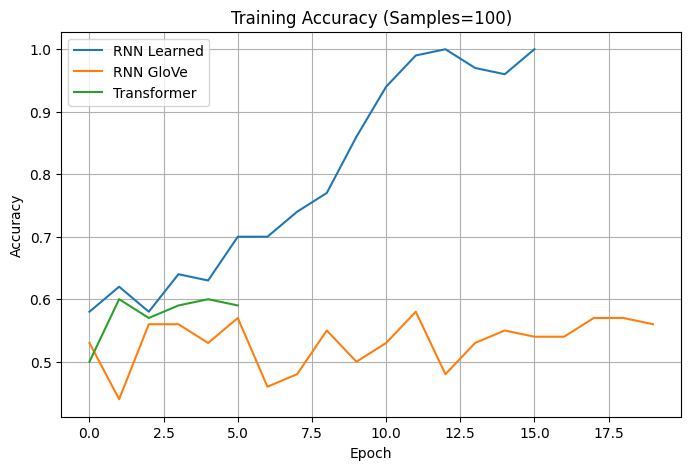


=== Performance Comparison (100 Samples) ===


,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Test Loss
0,RNN Learned,100.00%,61.15%,60.91%,0.5512,0.8861,0.8839
1,RNN GloVe,58.00%,49.48%,50.00%,0.9663,0.9895,0.9881
2,Transformer,58.00%,49.48%,50.00%,1.1001,1.1504,1.1466


In [ ]:
# Plot training accuracy for all models
plot_training_accuracy(
    [history_rnn_learned, history_rnn_glove, history_transformer],
    sample_size=100,
    model_names=["RNN Learned", "RNN GloVe", "Transformer"]
)

# Create comparison table
results_df = pd.DataFrame([rnn_learned_metrics, rnn_glove_metrics, transformer_metrics])

# Store these results for later use in Cell 7
initial_results = results_df.copy()
initial_results['Training Samples'] = 100

# Display formatted results
formatted_df = results_df.copy()
for col in ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']:
    formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")
for col in ['Train Loss', 'Validation Loss', 'Test Loss']:
    formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.4f}")

print("\n=== Performance Comparison (100 Samples) ===")
display(formatted_df)

# Comprehensive Sample Size Experiments (include 100 samples without retraining)

In [ ]:
sample_sizes = [100, 500, 1000, 5000, 25000 ]  # Now includes 100 for plotting
all_histories = []
experiment_results = []

# Add our initial 100-sample results
experiment_results.extend(initial_results.to_dict('records'))

# Only train on larger sample sizes
for size in [s for s in sample_sizes if s != 100]:
    print(f"\n=== Training with {size} samples ===")
    x_train_sub = x_train_full[:size]
    y_train_sub = y_train_full[:size]
    x_train_sub = keras.preprocessing.sequence.pad_sequences(x_train_sub, maxlen=maxlen)

    # Build fresh models for each experiment
    models = {
        "RNN Learned": build_rnn_learned(),
        "RNN GloVe": build_rnn_glove(),
        "Transformer": build_transformer()
    }

    size_histories = []
    for name, model in models.items():
        print(f"Training {name}...")
        history = model.fit(
            x_train_sub, y_train_sub,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, TqdmCallback(verbose=0)],
            verbose=0
        )
        size_histories.append(history)

        metrics = evaluate_model(
            model, name,
            x_train_sub, y_train_sub,
            x_val, y_val,
            x_test, y_test)
        metrics['Training Samples'] = size
        experiment_results.append(metrics)

    all_histories.append((size, size_histories))

# Create comprehensive results dataframe
exp_df = pd.DataFrame(experiment_results)


=== Training with 500 samples ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training RNN Learned...


0epoch [00:00, ?epoch/s]

Training RNN GloVe...


0epoch [00:00, ?epoch/s]

Training Transformer...


0epoch [00:00, ?epoch/s]


=== Training with 1000 samples ===
Training RNN Learned...


0epoch [00:00, ?epoch/s]

Training RNN GloVe...


0epoch [00:00, ?epoch/s]

Training Transformer...


0epoch [00:00, ?epoch/s]


=== Training with 5000 samples ===
Training RNN Learned...


0epoch [00:00, ?epoch/s]

Training RNN GloVe...


0epoch [00:00, ?epoch/s]

Training Transformer...


0epoch [00:00, ?epoch/s]


=== Training with 25000 samples ===
Training RNN Learned...


0epoch [00:00, ?epoch/s]

Training RNN GloVe...


0epoch [00:00, ?epoch/s]

Training Transformer...


0epoch [00:00, ?epoch/s]

# Comparison table and plots

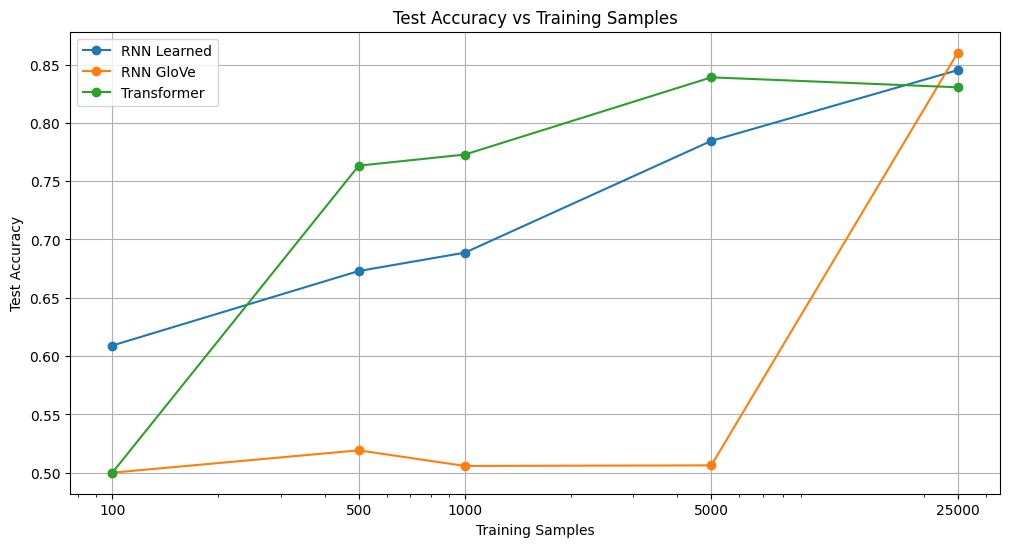


=== Final Comprehensive Results ===


,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Test Loss,Training Samples
1,RNN GloVe,58.00%,49.48%,50.00%,0.9663,0.9895,0.9881,100
0,RNN Learned,100.00%,61.15%,60.91%,0.5512,0.8861,0.8839,100
2,Transformer,58.00%,49.48%,50.00%,1.1001,1.1504,1.1466,100
4,RNN GloVe,56.60%,51.29%,51.92%,0.9401,0.9431,0.9429,500
3,RNN Learned,93.40%,68.03%,67.30%,0.4374,0.7457,0.7597,500
5,Transformer,98.60%,77.10%,76.33%,0.4177,0.8456,0.8634,500
7,RNN GloVe,53.00%,50.52%,50.58%,0.9068,0.9087,0.9088,1000
6,RNN Learned,91.80%,71.61%,68.87%,0.3871,0.7116,0.7499,1000
8,Transformer,97.50%,79.08%,77.28%,0.4240,0.7925,0.8187,1000
10,RNN GloVe,51.36%,51.11%,50.63%,0.7093,0.7098,0.7104,5000


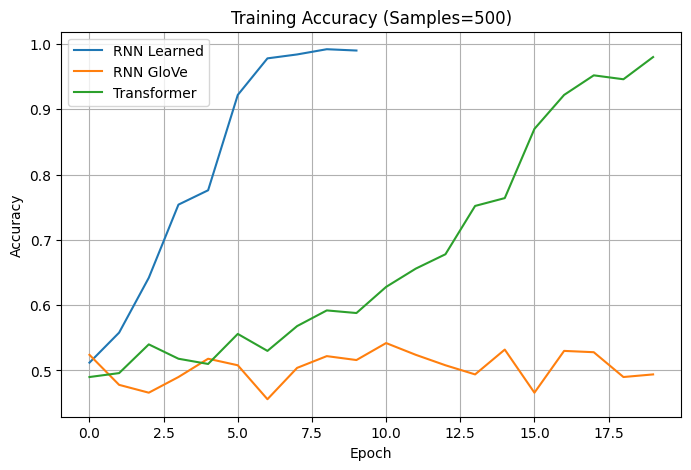

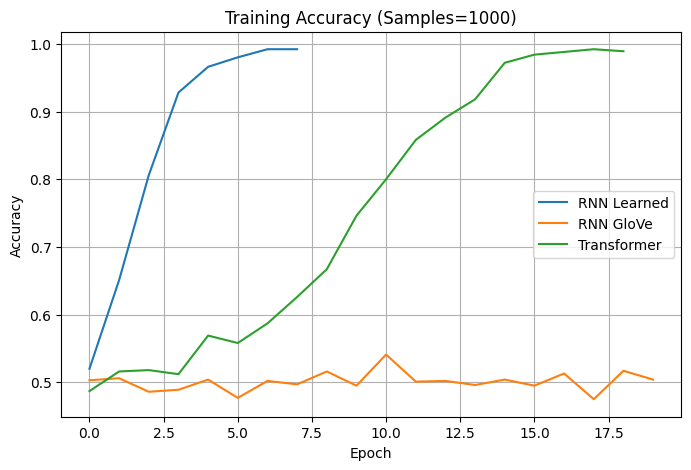

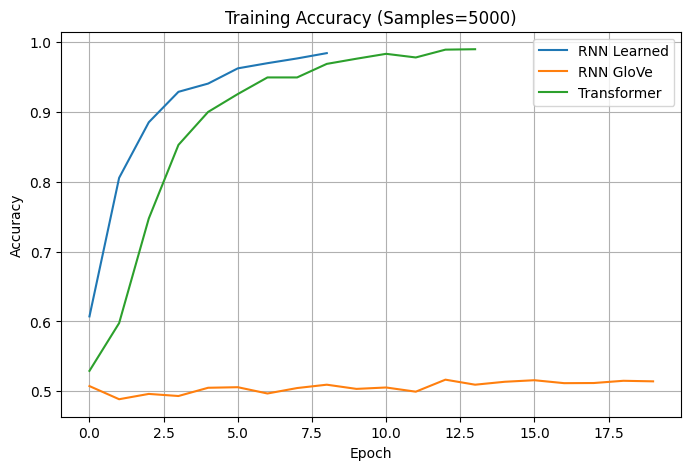

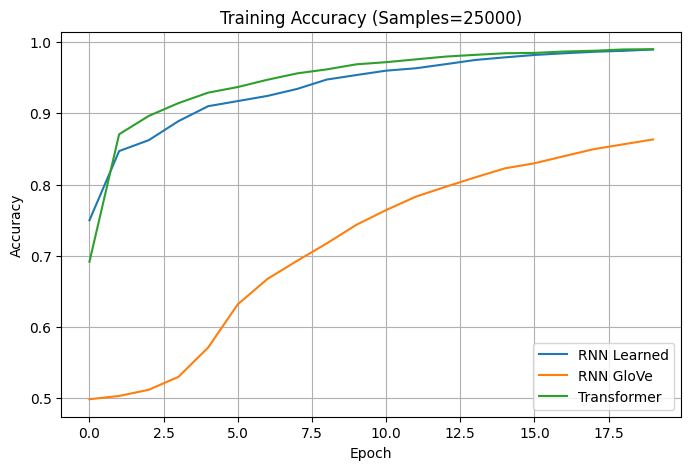

In [ ]:
# Plot sample size comparison
plot_sample_size_comparison(exp_df, metric='Accuracy')

# Create final results table with all metrics
final_results = exp_df.copy()
for col in ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']:
    final_results[col] = final_results[col].apply(lambda x: f"{x:.2%}")
for col in ['Train Loss', 'Validation Loss', 'Test Loss']:
    final_results[col] = final_results[col].apply(lambda x: f"{x:.4f}")

print("\n=== Final Comprehensive Results ===")
display(final_results.sort_values(['Training Samples', 'Model']))

# Plot training accuracy for each sample size (except 100 which we already plotted)
for size, histories in all_histories:
    plot_training_accuracy(
        histories,
        sample_size=size,
        model_names=["RNN Learned", "RNN GloVe", "Transformer"]
    )